In [311]:
import os, sys, math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats

from IPython.display import display

In [284]:
# load main lcr picker db, this is created in lcrPicker.py mergeDatabase()
# remember, mergeDatabase() is removing lcr occuring right before the spike (~ 150 ms)
# build in dualAnalysis fig9MergeDatabase()
path = '/Users/cudmore/Sites/SanPy/examples/dual-analysis/combined-sanpy-lcr-db.csv'
df = pd.read_csv(path, header=0)

df['lcrSlope'] *= 1000

print('num spikes:', len(df))
display(df.head())

num spikes: 429


,Unnamed: 0,index,file,detectionType,condition1,condition2,condition3,condition4,spikeNumber,numError,...,lcrNum,region,cell number,trial,analysisname,Condition,File Number,Sex,Region,filename
0,0,0,/Users/cudmore/Sites/SanPy/examples/dual-analy...,dvdt,NaN,NaN,NaN,NaN,0,0,...,9,inferior,19,19a,2021_02_19_0004_s0_00_s25_00,NaN,NaN,NaN,NaN,2021_02_19_0004
1,1,1,/Users/cudmore/Sites/SanPy/examples/dual-analy...,dvdt,NaN,NaN,NaN,NaN,1,0,...,1,inferior,19,19a,2021_02_19_0004_s0_00_s25_00,NaN,NaN,NaN,NaN,2021_02_19_0004
2,2,2,/Users/cudmore/Sites/SanPy/examples/dual-analy...,dvdt,NaN,NaN,NaN,NaN,2,0,...,1,inferior,19,19a,2021_02_19_0004_s0_00_s25_00,NaN,NaN,NaN,NaN,2021_02_19_0004
3,3,3,/Users/cudmore/Sites/SanPy/examples/dual-analy...,dvdt,NaN,NaN,NaN,NaN,3,0,...,2,inferior,19,19a,2021_02_19_0004_s0_00_s25_00,NaN,NaN,NaN,NaN,2021_02_19_0004
4,4,4,/Users/cudmore/Sites/SanPy/examples/dual-analy...,dvdt,NaN,NaN,NaN,NaN,4,1,...,2,inferior,19,19a,2021_02_19_0004_s0_00_s25_00,NaN,NaN,NaN,NaN,2021_02_19_0004


## Remove spikes that have very few lcr

In [303]:
# strip out spikes that have very few lcrNum
minNumLcrPerSpike = 1
print('numSpikes before stripping minNumLcrPerSpike:', minNumLcrPerSpike, len(df))
df = df[ df['lcrNum'] > minNumLcrPerSpike]
print('  after stripping minNumLcrPerSpike:', minNumLcrPerSpike, len(df))


numSpikes before stripping minNumLcrPerSpike: 1 242
  after stripping minNumLcrPerSpike: 1 242


## Analyze Ca delay/amp as a function of Vm spike

In [304]:
# 'caDelay_sec', 'caWidth_ms', 'lcrSlope', 'lcrNum'
palette ={"superior": "r", "inferior": "k"}


,region,count,mean,std,min,25%,50%,75%,max,sem,stat
0,inferior,93.0,1.191409,1.072570,-0.064502,0.407260,0.799520,1.657541,4.346359,0.111220,lcrSlope
1,superior,149.0,2.007679,2.084989,-1.119778,0.510013,1.356034,2.796820,8.964224,0.170809,lcrSlope


lcrSlope t-test results 3.495924856127807 0.0005626112625571377
lcrSlope mannwhitneyu results 8366.5 0.006653731445619842
savePath: /Users/cudmore/Sites/SanPy/examples/dual-analysis/fig9


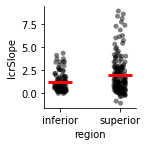

In [322]:
def myPlotRegions(df, theStat, groupBy=None, ySEM=True,ax=None):
    """
    General purpose region tables, stats, and plots
    
    Parameter:
        theStat: ['lcrNum', 'lcrSlope']
        groupBy: [None, 'cell number']
    """
    if ax is None:
        fig, ax = plt.subplots(1, 1)
        fig.set_size_inches(2, 2)
        fig.tight_layout()
        
    regionList = ['superior', 'inferior']
    palette ={"superior": "k", "inferior": "k"}

    #if theStat == 'lcrSlope'

    dfSup = df[df['region']=='superior']
    dfInf = df[df['region']=='inferior']
        
    
    # make table and run stats
    if groupBy is None:
        dfGroup = df.groupby('region')[theStat].describe()
        dfGroup = dfGroup.reset_index()
        # add sem column
        dfSem = df.groupby('region')[theStat].sem()
        dfSem = dfSem.reset_index()
        dfGroup['sem'] = dfSem[theStat]
        #
        dfGroup['stat'] = theStat
        display(dfGroup)
    else:
        dfBig = None
        for region in regionList:
            dfRegion = df[df['region']==region]
            dfGroup = dfRegion.groupby(groupBy)[theStat].describe()
            dfGroup = dfGroup.reset_index()
            # add sem column
            dfSem = dfRegion.groupby(groupBy)[theStat].sem()
            dfSem = dfSem.reset_index()
            dfGroup['sem'] = dfSem[theStat]
            #
            dfGroup['stat'] = theStat
            dfGroup['region'] = region
            if dfBig is None:
                dfBig = dfGroup
            else:
                dfBig = dfBig.append(dfGroup, ignore_index=True)
            #display(dfGroup)
        #
        display(dfBig)
  
    #
    # stats
    if groupBy is None:
        results = scipy.stats.ttest_ind(dfSup[theStat], dfInf[theStat])
        print(theStat, 't-test results', results.statistic, results.pvalue)
        results = scipy.stats.mannwhitneyu(dfSup[theStat], dfInf[theStat], alternative='two-sided')
        print(theStat, 'mannwhitneyu results', results.statistic, results.pvalue)

    #
    # plot
    if groupBy is None:
        plotDf = df
        plotStat = theStat
    else:
        plotDf = dfBig
        plotStat = 'mean'
    #
    whatWeArePlotting = sns.stripplot(x='region', y=plotStat,
                                hue='region',
                                hue_order=regionList,
                                      palette=palette,
                                alpha=0.5,
                                data=plotDf, ax=ax)

    # remove legend
    ax.legend([],[], frameon=False)

    #
    color = 'r'
    xd = [0,1] #df.groupby('region').mean()[theStat]
    yd = plotDf.groupby('region').mean()[plotStat]
    xerr = 0.2 # faking xerr to look like prism
    if ySEM:
        yerr = plotDf.groupby('region').sem()[plotStat]
    else:
        yerr = None
    ax.errorbar(xd, yd, xerr=xerr, yerr=yerr, fmt='none',
                lw=3, capsize=0, zorder=3, color=color, alpha=1);

    ax.set_ylabel(theStat)
    sns.despine()
    
    return fig, ax

# test
theStat = 'lcrSlope' # ['lcrNum', 'lcrSlope']
groupBy = None #[None, 'cell number', 'trial']
fig, ax = myPlotRegions(df, theStat, groupBy=groupBy, ySEM=False)
fig.set_size_inches(2, 2)
#ax.set_ylim(-.2,12.8)

savePath = '/Users/cudmore/Sites/SanPy/examples/dual-analysis/fig9'
print('savePath:', savePath)
plt.savefig(f'{savePath}/{theStat}.pdf', dpi=600, bbox_inches='tight')

## Count number of lcr per spike

,cell number,count,mean,std,min,25%,50%,75%,max,stat,region
0,2,66.0,3.742424,3.816203,0.0,1.0,2.5,6.00,16.0,lcrNum,superior
1,4,65.0,1.107692,1.288447,0.0,0.0,1.0,2.00,5.0,lcrNum,superior
2,6,16.0,7.125000,2.604483,0.0,6.0,7.5,8.25,11.0,lcrNum,superior
3,9,57.0,3.280702,2.320363,0.0,2.0,3.0,5.00,10.0,lcrNum,superior
4,11,46.0,2.108696,1.594829,0.0,1.0,2.0,3.00,8.0,lcrNum,superior


,cell number,count,mean,std,min,25%,50%,75%,max,stat,region
0,5,13.0,4.384615,2.142369,1.0,3.00,4.0,5.00,9.0,lcrNum,inferior
1,7,88.0,1.886364,1.663895,0.0,1.00,1.0,2.25,8.0,lcrNum,inferior
2,14,4.0,5.250000,2.872281,2.0,4.25,5.0,6.00,9.0,lcrNum,inferior
3,15,28.0,1.607143,1.257254,0.0,1.00,1.0,2.25,4.0,lcrNum,inferior
4,16,18.0,1.777778,1.699673,0.0,0.25,1.0,3.00,5.0,lcrNum,inferior
5,18,15.0,0.933333,1.437591,0.0,0.00,0.0,2.00,4.0,lcrNum,inferior
6,19,13.0,2.846154,2.303843,0.0,2.00,2.0,4.00,9.0,lcrNum,inferior


cn: lcrNum t-test results 0.7224275709449235 0.4865826168767967
cn: lcrNum mannwhitneyu results 22.0 0.5159516963585487


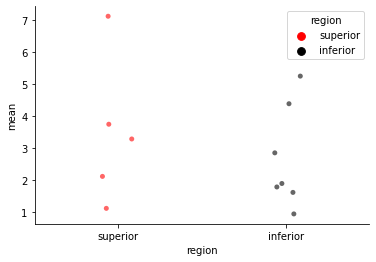

In [215]:
# per cell stats
theStat = 'lcrNum'
#theStat = 'lcrSlope'
dfSup = df[df['region']=='superior']
dfSupGroup = dfSup.groupby('cell number')[theStat].describe()
dfSupGroup = dfSupGroup.reset_index()
dfSupGroup['stat'] = theStat
dfSupGroup['region'] = 'superior'
display(dfSupGroup)

dfInf = df[df['region']=='inferior']
dfInfGroup = dfInf.groupby('cell number')[theStat].describe()
dfInfGroup = dfInfGroup.reset_index()
dfInfGroup['stat'] = theStat
dfInfGroup['region'] = 'inferior'
display(dfInfGroup)

results = scipy.stats.ttest_ind(dfSupGroup['mean'], dfInfGroup['mean'])
print('cn:', theStat, 't-test results', results.statistic, results.pvalue)
results = scipy.stats.mannwhitneyu(dfSupGroup['mean'], dfInfGroup['mean'], alternative='two-sided')
print('cn:', theStat, 'mannwhitneyu results', results.statistic, results.pvalue)

df2 = dfSupGroup.append(dfInfGroup)

whatWeArePlotting = sns.stripplot(x='region', y='mean', hue='region',
                            palette=palette,
                            alpha=0.6,
                            data=df2,
                            ax=None)
sns.despine()

,region,count,mean,std,min,25%,50%,75%,max,stat
0,inferior,179.0,2.078212,1.915204,0.0,1.0,2.0,3.0,9.0,lcrNum
1,superior,250.0,2.868000,2.937532,0.0,1.0,2.0,4.0,16.0,lcrNum


lcrNum t-test results 3.149147979293653 0.001752468795116172
lcrNum mannwhitneyu results 24915.5 0.04175226718337663


,region,count,mean,std,min,25%,50%,75%,max,stat
0,inferior,179.0,0.001199,0.001085,-0.000065,0.000396,0.000810,0.001717,0.004379,lcrSlope
1,superior,250.0,0.001659,0.002132,-0.001234,0.000204,0.000907,0.002501,0.008964,lcrSlope


lcrSlope t-test results 2.6489074602279867 0.0083746659154399
lcrSlope mannwhitneyu results 22596.5 0.8614516507413971


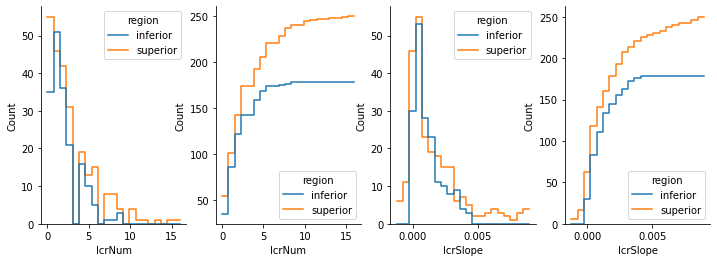

In [263]:
fig, axs = plt.subplots(1, 4)
fig.set_size_inches(12, 4)
# lcrNum
theStat = 'lcrNum'
#theStat = 'caDelay_sec'
g = sns.histplot(x=theStat, hue='region', 
                 cumulative=False, element="step", fill=False, 
                 #stat="density",
                 #common_norm=False,
                 ax=axs[0],
                 data=df)
g = sns.histplot(x=theStat, hue='region', 
                 cumulative=True, element="step", fill=False, 
                 #stat="density",
                 #common_norm=False,
                 ax=axs[1],
                 data=df)
# lcrSlope
theStat = 'lcrSlope'
#theStat = 'caWidth_ms'
g = sns.histplot(x=theStat, hue='region', 
                 cumulative=False, element="step", fill=False, 
                 #stat="density",
                 #common_norm=False,
                 ax=axs[2],
                 data=df)
g = sns.histplot(x=theStat, hue='region', 
                 cumulative=True, element="step", fill=False, 
                 #stat="density",
                 #common_norm=False,
                 ax=axs[3],
                 data=df)
sns.despine()

# test if num lcr per spike is significantly different between sup/inf

#
dfSup = df[df['region']=='superior']
dfInf = df[df['region']=='inferior']

# superior has significantly more lcr per spike
# 'caDelay_sec', 'caWidth_ms', 'lcrSlope', 'lcrNum'
theStat = 'lcrNum'
#theStat = 'caDelay_sec'
tmp = df.groupby('region')[theStat].describe()
tmp = tmp.reset_index()
tmp['stat'] = theStat
display(tmp)
results = scipy.stats.ttest_ind(dfSup[theStat], dfInf[theStat])
print(theStat, 't-test results', results.statistic, results.pvalue)
results = scipy.stats.mannwhitneyu(dfSup[theStat], dfInf[theStat], alternative='two-sided')
print(theStat, 'mannwhitneyu results', results.statistic, results.pvalue)

theStat = 'lcrSlope'
#theStat = 'caWidth_ms'
tmp = df.groupby('region')[theStat].describe()
tmp = tmp.reset_index()
tmp['stat'] = theStat
display(tmp)
results = scipy.stats.ttest_ind(dfSup[theStat], dfInf[theStat])
print(theStat, 't-test results', results.statistic, results.pvalue)
results = scipy.stats.mannwhitneyu(dfSup[theStat], dfInf[theStat], alternative='two-sided')
print(theStat, 'mannwhitneyu results', results.statistic, results.pvalue)



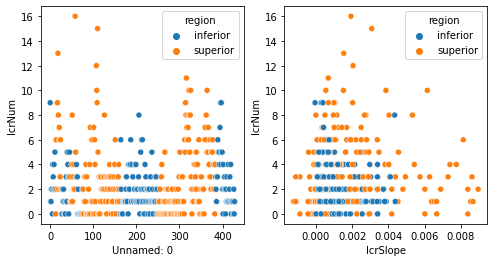

In [195]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(8, 4)

g = sns.scatterplot(x='Unnamed: 0', y='lcrNum', hue='region', data=df, ax=axs[0])
g = sns.scatterplot(x='lcrSlope', y='lcrNum', hue='region', data=df, ax=axs[1])


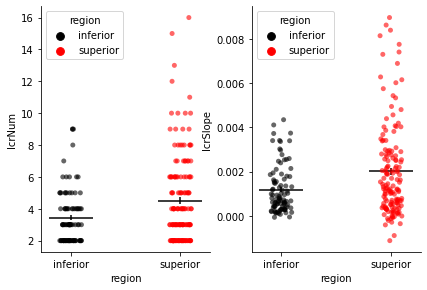

In [201]:
# plot raw data + mean +/- se
fig, axs = plt.subplots(1, 2)
plt.tight_layout()
#axs = [axs]
#fig.set_size_inches(6, 4)

# 'caDelay_sec', 'caWidth_ms', 'lcrSlope', 'lcrNum'
palette ={"superior": "r", "inferior": "k"}

theStat = 'lcrNum'
#theStat = 'caDelay_sec'
whatWeArePlotting = sns.stripplot(x='region', y=theStat, hue='region',
                            palette=palette,
                            alpha=0.6,
                            data=df, ax=axs[0])

color = 'k'
xd = [0,1] #df.groupby('region').mean()[theStat]
yd = df.groupby('region').mean()[theStat]
xerrd = df.groupby('region').sem()[theStat]
yerrd = df.groupby('region').sem()[theStat]
# faking xerr to look like prism
axs[0].errorbar(xd, yd, xerr=0.2, yerr=yerrd, fmt='none', capsize=0, zorder=1, color=color, alpha=1);

#
theStat = 'lcrSlope'
#theStat = 'caWidth_ms'
ax = axs[1]
whatWeArePlotting = sns.stripplot(x='region', y=theStat, hue='region',
                            palette=palette,
                            alpha=0.6,
                            data=df, ax=ax)

color = 'k'
xd = [0,1] #df.groupby('region').mean()[theStat]
#y = df.groupby('region')[theStat]
yd = df.groupby('region').mean()[theStat]
xerrd = df.groupby('region').sem()[theStat]
yerrd = df.groupby('region').sem()[theStat]
#ax.plot(xd, y, 'o')
ax.errorbar(xd, yd, xerr=.2, yerr=yerrd, fmt='none', capsize=0, zorder=1, color=color, alpha=1);

sns.despine()

lcrSlope


,count,mean,std,min,25%,50%,75%,max
region,,,,,,,,
inferior,93.0,0.001191,0.001073,-0.000065,0.000407,0.000800,0.001658,0.004346
superior,149.0,0.002008,0.002085,-0.001120,0.000510,0.001356,0.002797,0.008964


earlyDiastolicDurationRate


,count,mean,std,min,25%,50%,75%,max
region,,,,,,,,
inferior,83.0,23.572871,18.615167,-7.533869,8.984704,22.131721,35.520515,80.522732
superior,139.0,22.983322,20.910578,-17.128399,6.827900,15.898243,37.512546,81.493765


"\npopmean = 0\nfor region in regionList:\n    dfRegion = df[ df['region']==region ]\n    oneStat = dfRegion['lcrPreDepol'].tolist()\n    # remove nan\n    #oneStat = [x for x in oneStat if x!=np.nan]\n    statistic, pValue = scipy.stats.ttest_1samp(oneStat, popmean, nan_policy='omit')\n    print(region, 't:', round(statistic,3), 'p:', round(pValue,3))\n    \n    #display(dfRegion[yStat].describe())\n"

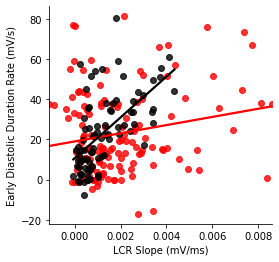

In [191]:
regionList = ['superior', 'inferior']
colorDict = {'superior':'r', 'inferior':'k'}
xStat = 'lcrSlope'
yStat = 'earlyDiastolicDurationRate'
for region in regionList:
    dfRegion = df[ df['region']==region ]
    #print(region, 'n=', len(dfRegion))
    color = colorDict[region]
    axGlobal = sns.regplot(x=xStat, y=yStat, data=dfRegion,
            ci=None, # turn off cconfidence intervals
            ax=None,
            color=color,
            label=region);

axGlobal.set_xlabel('LCR Slope (mV/ms)')
axGlobal.set_ylabel('Early Diastolic Duration Rate (mV/s)')

axGlobal.spines['right'].set_visible(False)
axGlobal.spines['top'].set_visible(False)

axGlobal.figure.set_size_inches(4, 4)

# based on particular values
if 0:
    axGlobal.set_xlim(0, 15)
    axGlobal.set_ylim(-16, 16)

print(xStat)
xtt = df.groupby('region')[xStat].describe()
display(xtt)
print(yStat)
ytt = df.groupby('region')[yStat].describe()
display(ytt)

# one sample t-test to ask "is LCR Depolarization > 0"
'''
popmean = 0
for region in regionList:
    dfRegion = df[ df['region']==region ]
    oneStat = dfRegion['lcrPreDepol'].tolist()
    # remove nan
    #oneStat = [x for x in oneStat if x!=np.nan]
    statistic, pValue = scipy.stats.ttest_1samp(oneStat, popmean, nan_policy='omit')
    print(region, 't:', round(statistic,3), 'p:', round(pValue,3))
    
    #display(dfRegion[yStat].describe())
'''

In [100]:
regions = ['superior', 'inferior']
for region in regions:
    print(region)
    
    dfRegion = df[ df['region'] == region]

    x_values = dfRegion[xStat]
    y_values = dfRegion[yStat]

    # strip nan, we are comparing a scatter plot, every x needs a y
    notNanIdx = ~np.isnan(x_values) & ~np.isnan(y_values) # strip nan

    n = np.sum(notNanIdx)
    
    resultObj = scipy.stats.linregress(x_values[notNanIdx], y_values[notNanIdx])
    print('  n:', n, 'slope:', round(resultObj.slope,3), 'p:', round(resultObj.pvalue,3))

    rTmp, pTmp = scipy.stats.pearsonr(x_values[notNanIdx], y_values[notNanIdx])
    print('  n:', n, 'pearsonsr r:', round(rTmp,3), 'p:', round(pTmp,3))


superior
  n: 139 slope: 2034.443 p: 0.021
  n: 139 pearsonsr r: 0.196 p: 0.021
inferior
  n: 83 slope: 10156.171 p: 0.0
  n: 83 pearsonsr r: 0.601 p: 0.0


In [94]:
regionList = ['superior', 'inferior']
colorDict = {'superior':'r', 'inferior':'k'}
xStat = 'lcrSlope'
yStat = 'earlyDiastolicDurationRate'
analysisName = 'cell number'
masterMeanDf = None
for region in regionList:

    #simplified version of above, one table per (region x xStat x yStat)
    #print(region, 'lcrSum')
    meanDf2 = dfRegion.groupby(analysisName)[xStat].describe()
    meanDf2 = meanDf2.reset_index()
    meanDf2['region'] = region
    meanDf2['stat'] = xStat
    display(meanDf2)

    #print(region, 'lcrPreDepol')
    meanDf3 = dfRegion.groupby(analysisName)[yStat].describe()
    meanDf3 = meanDf3.reset_index()
    meanDf3['region'] = region
    meanDf3['stat'] = yStat
    display(meanDf3)

    meanDf3 = meanDf3.append(meanDf2, ignore_index=True)
    if masterMeanDf is None:
        masterMeanDf = meanDf3
    else:
        masterMeanDf = masterMeanDf.append(meanDf3, ignore_index=True)
    

,cell number,count,mean,std,min,25%,50%,75%,max,region,stat
0,5,11.0,0.000532,0.000165,0.000307,0.000400,0.000540,0.000671,0.000755,superior,lcrSlope
1,7,22.0,0.002062,0.001145,0.000433,0.001324,0.001984,0.002863,0.004346,superior,lcrSlope
2,14,3.0,0.000262,0.000375,-0.000050,0.000054,0.000159,0.000418,0.000677,superior,lcrSlope
3,15,7.0,0.000534,0.000459,0.000069,0.000127,0.000437,0.000887,0.001206,superior,lcrSlope
4,16,6.0,0.001023,0.000346,0.000655,0.000821,0.000935,0.001135,0.001628,superior,lcrSlope
5,18,3.0,0.000208,0.000067,0.000150,0.000172,0.000194,0.000237,0.000281,superior,lcrSlope
6,19,5.0,0.000468,0.000343,0.000167,0.000281,0.000296,0.000575,0.001020,superior,lcrSlope


,cell number,count,mean,std,min,25%,50%,75%,max,region,stat
0,5,9.0,12.388535,10.249579,-7.533869,8.741476,13.897791,14.854557,30.502661,superior,earlyDiastolicDurationRate
1,7,22.0,34.900186,10.904462,17.307601,26.340166,34.255398,41.747099,61.295100,superior,earlyDiastolicDurationRate
2,14,2.0,-0.377083,0.714973,-0.882644,-0.629863,-0.377083,-0.124302,0.128479,superior,earlyDiastolicDurationRate
3,15,7.0,14.389558,6.986472,5.653917,9.161562,14.673728,19.248187,23.579762,superior,earlyDiastolicDurationRate
4,16,5.0,26.394262,26.184361,2.135354,4.855728,15.963386,54.026324,54.990518,superior,earlyDiastolicDurationRate
5,18,2.0,7.803005,2.015152,6.378078,7.090541,7.803005,8.515469,9.227933,superior,earlyDiastolicDurationRate
6,19,4.0,1.941869,2.685890,-1.239628,0.579640,1.916067,3.278296,5.174970,superior,earlyDiastolicDurationRate


,cell number,count,mean,std,min,25%,50%,75%,max,region,stat
0,5,11.0,0.000532,0.000165,0.000307,0.000400,0.000540,0.000671,0.000755,inferior,lcrSlope
1,7,22.0,0.002062,0.001145,0.000433,0.001324,0.001984,0.002863,0.004346,inferior,lcrSlope
2,14,3.0,0.000262,0.000375,-0.000050,0.000054,0.000159,0.000418,0.000677,inferior,lcrSlope
3,15,7.0,0.000534,0.000459,0.000069,0.000127,0.000437,0.000887,0.001206,inferior,lcrSlope
4,16,6.0,0.001023,0.000346,0.000655,0.000821,0.000935,0.001135,0.001628,inferior,lcrSlope
5,18,3.0,0.000208,0.000067,0.000150,0.000172,0.000194,0.000237,0.000281,inferior,lcrSlope
6,19,5.0,0.000468,0.000343,0.000167,0.000281,0.000296,0.000575,0.001020,inferior,lcrSlope


,cell number,count,mean,std,min,25%,50%,75%,max,region,stat
0,5,9.0,12.388535,10.249579,-7.533869,8.741476,13.897791,14.854557,30.502661,inferior,earlyDiastolicDurationRate
1,7,22.0,34.900186,10.904462,17.307601,26.340166,34.255398,41.747099,61.295100,inferior,earlyDiastolicDurationRate
2,14,2.0,-0.377083,0.714973,-0.882644,-0.629863,-0.377083,-0.124302,0.128479,inferior,earlyDiastolicDurationRate
3,15,7.0,14.389558,6.986472,5.653917,9.161562,14.673728,19.248187,23.579762,inferior,earlyDiastolicDurationRate
4,16,5.0,26.394262,26.184361,2.135354,4.855728,15.963386,54.026324,54.990518,inferior,earlyDiastolicDurationRate
5,18,2.0,7.803005,2.015152,6.378078,7.090541,7.803005,8.515469,9.227933,inferior,earlyDiastolicDurationRate
6,19,4.0,1.941869,2.685890,-1.239628,0.579640,1.916067,3.278296,5.174970,inferior,earlyDiastolicDurationRate


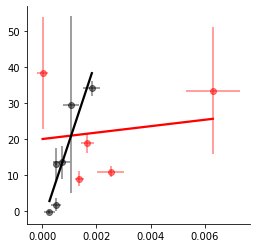

In [95]:
hue = 'region'
xStat = 'lcrSlope'
yStat = 'earlyDiastolicDurationRate'
analysisName = 'cell number'
regionList = ['superior', 'inferior']
colorDict = {'superior':'r', 'inferior':'k'}

doError = True

fig, axs = plt.subplots(1, 1)

for idx, region in enumerate(regionList):
    color = colorDict[region]

    dfRegion = df[ df['region']==region ]
 
    dfRegion = dfRegion[ dfRegion['lcrNum'] > 3]

    xd = dfRegion.groupby([analysisName]).mean()[xStat]
    yd = dfRegion.groupby([analysisName]).mean()[yStat]
    
    axHue = sns.regplot(x=xd, y=yd,
            ci=None, # turn off confidence intervals
            ax=axs,
            color=color,
            scatter_kws={'alpha':0.5},
            label=region);
    #
    # add error bars with matplotlib (dfRegion is for current region, ALL ORIGINAL DATA)
    if doError:
        xd = dfRegion.groupby([analysisName]).mean()[xStat]
        yd = dfRegion.groupby([analysisName]).mean()[yStat]
        xerrd = dfRegion.groupby([analysisName]).sem()[xStat]
        yerrd = dfRegion.groupby([analysisName]).sem()[yStat]
        axs.errorbar(xd, yd, xerr=xerrd, yerr=yerrd, fmt='none', capsize=0, zorder=1, color=color, alpha=0.5);

axs.figure.set_size_inches(4, 4)

axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)

axs.set_xlabel('')
axs.set_ylabel('')

# based on particular values
if 0:
    axs.set_ylim(-4, 5)
    axs.set_xlim(0, 6)

In [77]:
# per cell stats

for region in regionList:
    dfRegion = df[ df['region']==region ]

    print('. ', region, 'before stripping lcrNum<=3', len(dfRegion))
    # remove spikes that have fewer than 3 lcrNum
    dfRegion = dfRegion[ dfRegion['lcrNum'] > 3]
    print('    after stripping lcrNum<=3', len(dfRegion))
    
    xd = dfRegion.groupby(analysisName)[xStat].mean()
    yd = dfRegion.groupby(analysisName)[yStat].mean()

    # strip nan, we are comparing a scatter plot, every x needs a y
    # we generally do not get nan values here
    notNanIdx = ~np.isnan(xd) & ~np.isnan(yd) # strip nan
    
    n = np.sum(notNanIdx)

    resultObj = scipy.stats.linregress(xd[notNanIdx], yd[notNanIdx])
    print('  region:', region, 'slope:', round(resultObj.slope,3), 'r:', round(resultObj.rvalue,3), 'p:', round(resultObj.pvalue,3), sep='\t')

    rTmp, pTmp = scipy.stats.pearsonr(xd[notNanIdx], yd[notNanIdx])
    print('  region:', region, 'pearsonsr r:', round(rTmp,3), 'p:', round(pTmp,3), sep='\t')


.  superior before stripping lcrNum<=3 76
    after stripping lcrNum<=3 76
  region:	superior	slope:	890.943	r:	0.16	p:	0.797
  region:	superior	pearsonsr r:	0.16	p:	0.797
.  inferior before stripping lcrNum<=3 36
    after stripping lcrNum<=3 36
  region:	inferior	slope:	22680.744	r:	0.908	p:	0.012
  region:	inferior	pearsonsr r:	0.908	p:	0.012


In [78]:
# ask if there is a significant difference between (superior, inferior) for (lcr slope, EDD Rate)


In [79]:
# redo lcr sclope vs eddr taking into account lcrNum per spike
# the way I calculat lcrSlope, it also calculates for 0 lcr WHICH IS NOT USEFUL !!!


In [80]:
# I NEED TO ACCOUNT FOR CELLS THAT ARE JUST ANALYZING ONE SPIKE
# -->> NOT ENOUGH DATA !!!!